In [3]:
import sys
import random
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.append("..")
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.temporal_model_utils import *

sys.path.append("../..")
from cyclops.feature_handler import FeatureHandler

%load_ext autoreload
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
DIR="/mnt/nfs/project/delirium/drift_exp/MAY-31-2022/"
feature_handler = FeatureHandler()
feature_handler.load(DIR, "test_features")

2022-06-06 13:16:29,470 INFO cyclops.feature_handler - Loading features from file...
2022-06-06 13:16:29,479 INFO cyclops.feature_handler - Found file to load for static features...
2022-06-06 13:16:29,479 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-06-06 13:16:29,657 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-06-06 13:16:29,927 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


<IPython.core.display.Javascript object>

In [6]:
ref_static = feature_handler.reference['static']

<IPython.core.display.Javascript object>

In [7]:
static = feature_handler.features['static']
print("Encounters:",static.shape[0])
print("Static Features:",static.shape[1])

Encounters: 5064
Static Features: 25


<IPython.core.display.Javascript object>

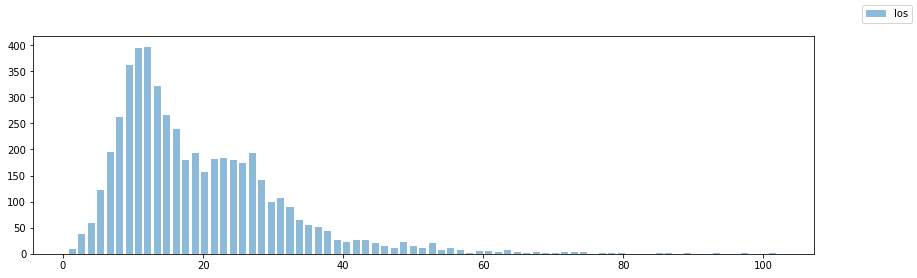

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.hist(static["length_of_stay_in_er"], bins=75, alpha=0.5, width=1, label="los")
fig.legend(loc="upper right")
plt.show()

In [11]:
static = process_outcome("length_of_stay_in_er", static)

<IPython.core.display.Javascript object>

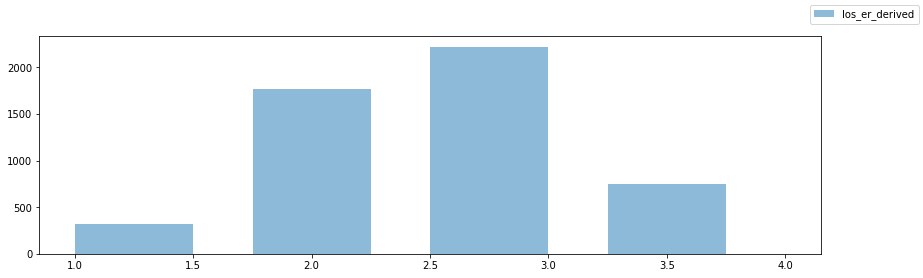

<IPython.core.display.Javascript object>

In [12]:
fig, ax = plt.subplots(figsize=(14, 4))
plt.hist(static["los_er_derived"], bins=4, alpha=0.5, width=0.5, label="los_er_derived")
fig.legend(loc="upper right")
plt.show()

In [14]:
ref_temporal = feature_handler.reference['temporal']

<IPython.core.display.Javascript object>

In [15]:
temporal = feature_handler.features['temporal']
samples=len(temporal.index.unique(level=0))
timesteps=len(temporal.index.unique(level=1))
features=temporal.shape[1]
print("Encounters:",samples)
print("Timesteps:",timesteps)
print("Temporal Features:",features)

Encounters: 4613
Timesteps: 8
Temporal Features: 12


<IPython.core.display.Javascript object>

In [17]:
temporal = temporal.rename_axis("features", axis="columns")

<IPython.core.display.Javascript object>

In [ ]:
outcome = "los_er_derived"
batch_size = 1
input_dim = features*3
output_dim = 1
hidden_dim = 128
layer_dim = 1
dropout = 0.2
n_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-6

device = get_device()

X = temporal[np.in1d(temporal.index.get_level_values(0), static.index.get_level_values(0))]
y = static[np.in1d(static.index.get_level_values(0), X.index.get_level_values(0))]
y_train, y_val = train_test_split(y, test_size=1/2)
y_val, y_test = train_test_split(y_val, test_size=1/2)
X_train = X[np.in1d(X.index.get_level_values(0), y_train.index.get_level_values(0))]
X_train_inputs = format_dataset(X_train, level="features",imputation_method="simple")
X_val = X[np.in1d(X.index.get_level_values(0), y_val.index.get_level_values(0))]
X_val_inputs = format_dataset(X_val, level="features",imputation_method="simple")
X_test = X[np.in1d(X.index.get_level_values(0), y_test.index.get_level_values(0))]
X_test_inputs = format_dataset(X_test, level="features",imputation_method="simple")
y_train = y_train[[outcome]].to_numpy().reshape(len(y_train),1)
y_val = y_val[[outcome]].to_numpy().reshape(len(y_val),1)
y_test = y_test[[outcome]].to_numpy().reshape(len(y_test),1)

train_dataset = get_data(X_train_inputs,y_train)
train_loader = train_dataset.to_loader(batch_size) 

val_dataset = get_data(X_val_inputs,y_val)
val_loader = val_dataset.to_loader(batch_size)

In [ ]:
model_params = {'device': device,
                'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_temporal_model('lstmcell', model_params).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
activation = nn.Softmax(dim=1)
opt = Optimizer(model=model, loss_fn=loss_fn, optimizer=optimizer,activation=activation)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

In [ ]:
test_dataset = get_data(X_test_inputs,y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)
predictions, values, tags = opt.evaluate(test_loader, batch_size=1, n_features=input_dim)

In [ ]:
df_result = format_predictions(predictions, values, tags, X_test)

In [ ]:
df_result.head(n=20)